In [1]:
# Import all necessity functions for Machine Learning
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import cv2
import os
import random
from collections import Counter
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, silhouette_score

In [2]:
# Remove all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# To Access the Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# To Unzip the folder
link_folder = '/content/drive/MyDrive/CNN Dataset/Tumor.zip'
zip_ref = zipfile.ZipFile(link_folder, 'r')
zip_ref.extractall()
zip_ref.close()

#####Data Augmentation


In [5]:
!pip install Augmentor

In [6]:
import Augmentor
p = Augmentor.Pipeline("/content/Modified_Dataset/Train")

Initialised with 1050 image(s) found.
Output directory set to /content/Modified_Dataset/Train/output.

In [7]:
"""
    Data augmentation is a technique commonly used in machine learning and deep learning to artificially increase the size of a dataset by
    applying various transformations to the existing data.
    The goal of data augmentation is to create new and diverse variations of the original data samples,
    which helps improve the model's generalization and robustness.

    Image Augmentation:

      Rotation: Rotating images by certain angles.
      Flip: Flipping images horizontally or vertically.
      Crop: Cropping images to different sizes or positions.
      Zoom: Zooming in or out on images.
      Color Jitter: Adjusting the brightness, contrast, and saturation of images.
      Adding Noise: Adding random noise to images.
"""
SAMPLE_GENERATE = 2500
# Rotate the Image
p.rotate(probability=0.3, max_left_rotation=10, max_right_rotation=10)

# Flip the Image
p.flip_left_right(probability=0.3)

# Cropping the Image randomly
p.crop_random(probability=.1, percentage_area=0.2)

# Resizing the Image
p.resize(probability=0.3, width=100, height=100)

# Random Brightness
p.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)

# Random color
p.random_color(probability=0.5, min_factor=0.4, max_factor=0.9)

# Ranodm Contrast
p.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)

# Zoomimg the Image
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

# Change the samples size according to requirements
p.sample(SAMPLE_GENERATE)

Processing <PIL.Image.Image image mode=L size=40x34 at 0x7A5FBBF1B970>: 100%|██████████| 2500/2500 [00:17<00:00, 146.36 Samples/s]


#####Extract the train augmented data

In [8]:
DIRECTORY  = '/content/Modified_Dataset/Train/output'
CATEGORIES = ['BENIGN', 'MALIGNANT', 'NORMAL']
STORE_DATA = []

for category in CATEGORIES:
  FOLDER_PATH = os.path.join(DIRECTORY, category)

  for IMAGE in os.listdir(FOLDER_PATH):
    IMAGE_PATH  = os.path.join(FOLDER_PATH, IMAGE)
    IMAGE_ARRAY = cv2.resize(cv2.imread(IMAGE_PATH), (120, 120))
    IMAGE_LABEL = CATEGORIES.index(category)

    STORE_DATA.append([IMAGE_ARRAY, IMAGE_LABEL])

  print("Folder {} is completed.".format(category))
  print("_"*30)

Folder BENIGN is completed.
______________________________
Folder MALIGNANT is completed.
______________________________
Folder NORMAL is completed.
______________________________


#####Extract the Validation data - No-augmented

In [9]:
DIRECTORY  = '/content/Modified_Dataset/Test'
CATEGORIES = ['BENIGN', 'MALIGNANT', 'NORMAL']
TEST_DATA = []

for category in CATEGORIES:
  FOLDER_PATH = os.path.join(DIRECTORY, category)

  for IMAGE in os.listdir(FOLDER_PATH):
    IMAGE_PATH  = os.path.join(FOLDER_PATH, IMAGE)
    IMAGE_ARRAY = cv2.resize(cv2.imread(IMAGE_PATH), (120, 120))
    IMAGE_LABEL = CATEGORIES.index(category)

    TEST_DATA.append([IMAGE_ARRAY, IMAGE_LABEL])

  print("Folder {} is completed.".format(category))
  print("_"*30)

Folder BENIGN is completed.
______________________________
Folder MALIGNANT is completed.
______________________________
Folder NORMAL is completed.
______________________________


#####Shuffle the Image

In [10]:
random.shuffle(STORE_DATA)
random.shuffle(TEST_DATA)

print("Shuffle is done.")

Shuffle is done.


In [11]:
print("Length of Train data # {} ".format(len(STORE_DATA)))
print("Length of Test data  # {} ".format(len(TEST_DATA)))

Length of Train data # 2500 
Length of Test data  # 144 


#####Split the dataset into train and test

In [12]:
X = []
y = []

for (independent, dependent) in STORE_DATA:
  X.append(independent)
  y.append(dependent)

print("Splitting is done".capitalize())

Splitting is done


In [13]:
X_val = []
y_val = []

for (independent, dependent) in TEST_DATA:
  X_val.append(independent)
  y_val.append(dependent)

print("Splitting is done".capitalize())

Splitting is done


#####Convert into NumPy Array

In [14]:
X = np.array(X)
y = np.array(y)

X_val = np.array(X_val)
y_val = np.array(y_val)

print("Conversion into NumPy is done.".capitalize())

Conversion into numpy is done.


#####Display some of the Images

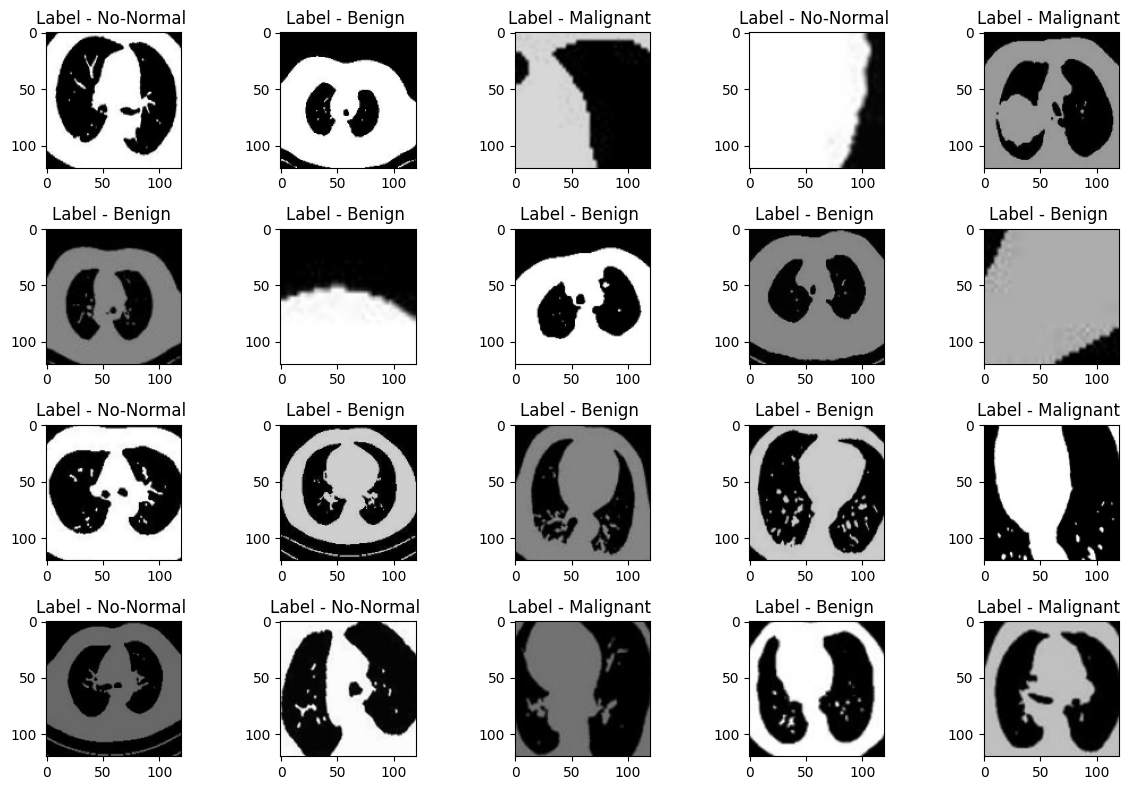

In [15]:
lower_limit = 0
upper_limit = 20
number_row  = 4
number_col  = 5

IMAGE = X[lower_limit : upper_limit]
LABEL = y[lower_limit : upper_limit]

plt.figure(figsize = (12, 8))
for index, image in enumerate(IMAGE):
  plt.subplot(number_row, number_col, index + 1)
  plt.imshow(image)
  plt.title("Label - {} ".format('Benign' if LABEL[index] == 0\
                                 else 'Malignant' if LABEL[index] == 1\
                                 else 'No-Normal'))

plt.tight_layout()
plt.show()

#####Do the Normalization

In [16]:
X = X/255

print("Normalization is done.".capitalize())

Normalization is done.


In [17]:
X_val = X_val / 255

print("Normalization is done.".capitalize())

Normalization is done.


#####Check the distribution of target class

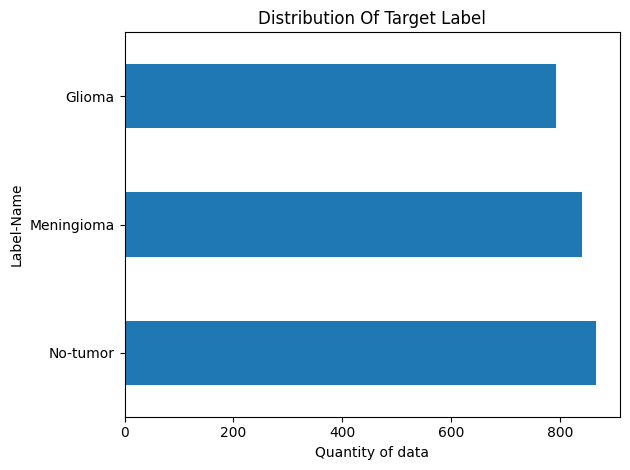

In [18]:
pd.DataFrame(y, columns = ['Target']).applymap(lambda x: 'Glioma' if x == 0\
                                               else 'Meningioma' if x == 1\
                                               else 'No-tumor' if x == 2\
                                               else 'Pituitary')['Target'].\
                                               value_counts().plot(kind = 'barh')

plt.title('Distribution of Target label'.title())
plt.xlabel('Quantity of data')
plt.ylabel('Label-Name')
plt.tight_layout()
plt.show()

#####Split the dataset into train and test

In [19]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models

In [20]:
# Change the shape of the X
CHANNEL = 3
HEIGHT  = 120
WIDTH   = 120

X = X.reshape(X.shape[0], CHANNEL, HEIGHT, WIDTH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X,\
                                                    y,\
                                                    test_size = 0.30,\
                                                    random_state = 42)

# Convert the train and test into Float with respect to torch
X_train = torch.tensor(data = X_train,\
                       dtype = torch.float32)

y_train = torch.tensor(data = y_train,\
                       dtype = torch.float32)

X_test  = torch.tensor(data = X_test,\
                       dtype = torch.float32)

y_test  = torch.tensor(data = y_test,\
                       dtype = torch.float32)

print("X_train shape # {} ".format(X_train.shape), '\n')
print("y_train shape # {} ".format(y_train.shape), '\n')
print("X_test shape  # {} ".format(X_test.shape), '\n')
print("y_test shape  # {} ".format(y_test.shape), '\n')

print("_"*60, '\n')

# Call the DataLoader with batch_size = 64
BATCH_SIZE = 64

TRAIN_LOADER = DataLoader(dataset = list(zip(X_train, y_train)),\
                          batch_size = BATCH_SIZE,\
                          shuffle = True)

TEST_LOADER  = DataLoader(dataset = list(zip(X_test, y_test)),\
                          batch_size = BATCH_SIZE,\
                          shuffle = True)

print("Batch size of Train # {} ".format(TRAIN_LOADER.batch_size), '\n')
print("Batch size of Test  # {} ".format(TEST_LOADER.batch_size), '\n')

print("_"*60, '\n')

# Extract the data and label
train_data, train_label = next(iter(TRAIN_LOADER))
test_data, test_label   = next(iter(TEST_LOADER))

print("Train data with single batch_size  # {} ".format(train_data.shape), '\n')
print("Train label with single batch_size # {} ".format(train_label.shape), '\n')
print("Test data with single batch_size  # {} ".format(test_data.shape), '\n')
print("Test label with single batch_size # {} ".format(test_label.shape))

X_train shape # torch.Size([1750, 3, 120, 120])  

y_train shape # torch.Size([1750])  

X_test shape  # torch.Size([750, 3, 120, 120])  

y_test shape  # torch.Size([750])  

____________________________________________________________ 

Batch size of Train # 64  

Batch size of Test  # 64  

____________________________________________________________ 

Train data with single batch_size  # torch.Size([64, 3, 120, 120])  

Train label with single batch_size # torch.Size([64])  

Test data with single batch_size  # torch.Size([64, 3, 120, 120])  

Test label with single batch_size # torch.Size([64]) 


#####Initialize the GPU

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


#####Model building....

In [22]:
"""
    1. Create a class named TumorClassification with TWO parameters
      1.1 input_channel: Define whether the image is RGB or GRAY
      1.2 output_dimension: Define the target class. == 1 menas binary class and > 1 means multi-class classification
    2. Call the super function that will inherit the parent class of torch
"""
class TumorClassification(nn.Module):
  def __init__(self, input_channels = None, output_dimension = None):
    super().__init__()

    """
        Create the Left most, Right most, Convolutional Layer that will take
          1. in_channels : Define the input_channels - in this case, 3(means RGB Image)
          2. out_channels : Define the output channels after being done the convolution operation
          3. kernel_size : Define the kernel/filter that will be placed on top of images so that we can extract the Feature Map
          4. stride : Define how much this kernel would be moved (TOP->BOTTOM->LEFT->RIGHT)
          5. padding : Define whether the Feature Map would be equivalent to orginal Image shape or not. == 1 means orginal & 0 == means might be changed.

        Define the Activation Layer so that we can pass the information to the subsequent layers/neurons. In this case, ReLU activation - prevent the vanishing gradient

        MaxPooling : Do the down-sampling on top of Feature Map so that we can prevent Translation invariance and overfitting problem
          1. kernel_size: In this case, (2, 2) - initially it would be filled with random numbers but it is trainable parameters
          2. stride : In this case, (2, 2) - The Feature map that we would be obtained would be half of the orginal Image

        Dropout : Dropout Layer is generally used to prevent the overfitting problem. In this case, 0.4 for all Convolutional Layer

        # Conv1 Convolutional Layer
            Image Shape : 120 * 120 * 3 -> 60 * 60 * 32 - > 30 * 30 * 16
        # Conv2 Convolutional Layer
            Image Shape : 120 * 120 * 3 -> 60 * 60 * 64 - > 30 * 30 * 32
    """
    self.CONV1_LAYER = self.conv1_block(input_channel = input_channels, output_channels = 32)
    self.CONV2_LAYER = self.conv2_block(input_channel = input_channels, output_channels = 64)

    self.FC1_LAYER   = self.fc1_block(input_features = 30 * 30 * 16, output_features = 32, dropout = 0.4)
    self.FC2_LAYER   = self.fc2_block(input_features = 30 * 30 * 32, output_features = 64, dropout = 0.5)

    self.OUT_LAYER1  = self.output_layer(input_features = 32, output_features = output_dimension)
    self.OUT_LAYER2  = self.output_layer(input_features = 32, output_features = output_dimension)

    self.FC3_LAYER   = self.fc1_block(input_features = 64 , output_features = 16, dropout = 0.3)
    self.OUT_LAYER3  = self.output_layer(input_features = 16, output_features = output_dimension)

  def conv1_block(self, input_channel = None, output_channels = None):
    return nn.Sequential(
        nn.Conv2d(in_channels  = input_channel,\
                  out_channels = output_channels,\
                  kernel_size = (2, 2),\
                  stride  = (1, 1),\
                  padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = (2, 2),\
                     stride = (2, 2)),
        nn.Dropout(p = 0.2),

        nn.Conv2d(in_channels  = 32,\
                  out_channels = 16,\
                  kernel_size = (2, 2),\
                  stride  = (1, 1),\
                  padding = 1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),\
                     stride = (2, 2))

    )

  def conv2_block(self, input_channel = None, output_channels = None):
    return nn.Sequential(
        nn.Conv2d(in_channels  = input_channel,\
                  out_channels = output_channels,\
                  kernel_size = (2, 2),\
                  stride  = (1, 1),\
                  padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = (2, 2),\
                     stride = (2, 2)),
        nn.Dropout(p = 0.3),

        nn.Conv2d(in_channels  = 64,\
                  out_channels = 32,\
                  kernel_size = (2, 2),\
                  stride  = (1, 1),\
                  padding = 1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),\
                     stride = (2, 2))

   )

  def fc1_block(self, input_features = None, output_features = None, dropout = None):
    """
        Create the Sequentila Fully Connected Layer for LEFT, MIDDLE, RIGHT
          1. in_features : There, we will fill the Feature Map shape after being completed each Convolutional Operation
          2. out_features : There, Define how many neurons that we want

        BatchNormalization is used to make their distribution into the same shape so that gradient would be stable to reach the Global minima
    """
    return nn.Sequential(
        nn.Linear(in_features  = input_features,\
                  out_features = output_features),
        nn.ReLU(),
        nn.Dropout(p = dropout)

    )

  def fc2_block(self,  input_features = None, output_features = None, dropout = None):
    """
        Create the Sequentila Fully Connected Layer for LEFT, MIDDLE, RIGHT
          1. in_features : There, we will fill the Feature Map shape after being completed each Convolutional Operation
          2. out_features : There, Define how many neurons that we want

        BatchNormalization is used to make their distribution into the same shape so that gradient would be stable to reach the Global minima
    """
    return nn.Sequential(
        nn.Linear(in_features  = input_features,\
                  out_features = output_features),
        nn.LeakyReLU(),
        nn.Dropout(p = dropout),

        nn.Linear(in_features  = 64,\
                  out_features = 32),
        nn.ReLU()

    )

  def output_layer(self, input_features = None, output_features = None):
    """
        Create the Sequentila Fully Connected Layer
          1. in_features : There, we will fill the Feature Map shape after being completed each Convolutional Operation
          2. out_features : There, Define how many neurons that we want

        BatchNormalization is used to make their distribution into the same shape so that gradient would be stable to reach the Global minima
    """
    return nn.Sequential(
        nn.Linear(in_features  = input_features,\
                  out_features = output_features),
        nn.Softmax()

    )

  def extra_layer(self, input_features = None, output_features = None):
    pass

  def forward(self, x):
    """
        1. Pass the Independent Features to all LEFT, MIDDLE, RIGHT
        2. Definately, change their shape so that we can pass the result to the Fully Connected layer
        3. Return the output

        First, pass the data - x - into the two separate convolutional layer
        Second, Do the Flatten operation so that we can pass the data to FC layer
        Third, Do the concat operation with dim = 1: meaning that it would be appended with respect to column-wise
        Fourth, Pass the Feature map to separate layers (128, 64) and do the concat atlast
        Finally, the data passed to the FC layer to give the output
    """
    CONV1 = self.CONV1_LAYER(x)
    CONV2 = self.CONV2_LAYER(x)

    CONV1 = CONV1.reshape(CONV1.shape[0], -1)
    CONV2 = CONV2.reshape(CONV2.shape[0], -1)

    FC1 = self.FC1_LAYER(CONV1)
    FC2 = self.FC2_LAYER(CONV2)

    OUT1 = self.OUT_LAYER1(FC1)
    OUT2 = self.OUT_LAYER2(FC2)

    CONCAT = torch.concat((FC1, FC2),\
                          dim = 1)

    FC3 = self.FC3_LAYER(CONCAT)
    OUT3 = self.OUT_LAYER3(FC3)

    return OUT1, OUT2, OUT3

In [23]:
try:
  RGB   = 3
  model = TumorClassification(input_channels = RGB, output_dimension = 3)
except Exception as e:
  print(e.with_traceback())
else:
  print(model.parameters)

<bound method Module.parameters of TumorClassification(
  (CONV1_LAYER): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (CONV2_LAYER): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=F

In [24]:
# Connect the model into GPU
model = model.to(device)

In [25]:
# Find the total trainable parameters
TOTAL_PARAMETERS = 0
for name, params in model.named_parameters():
  if params.requires_grad:
    print("Layer - {} & trainable parameters # {} ".upper().format(name, params.numel()))
    print("_"*60)
    TOTAL_PARAMETERS+= params.numel()
  else:
    pass

print("\ntotal number of trainable parameters # {} ".upper().format(TOTAL_PARAMETERS))

LAYER - CONV1_LAYER.0.weight & TRAINABLE PARAMETERS # 384 
____________________________________________________________
LAYER - CONV1_LAYER.0.bias & TRAINABLE PARAMETERS # 32 
____________________________________________________________
LAYER - CONV1_LAYER.4.weight & TRAINABLE PARAMETERS # 2048 
____________________________________________________________
LAYER - CONV1_LAYER.4.bias & TRAINABLE PARAMETERS # 16 
____________________________________________________________
LAYER - CONV2_LAYER.0.weight & TRAINABLE PARAMETERS # 768 
____________________________________________________________
LAYER - CONV2_LAYER.0.bias & TRAINABLE PARAMETERS # 64 
____________________________________________________________
LAYER - CONV2_LAYER.4.weight & TRAINABLE PARAMETERS # 8192 
____________________________________________________________
LAYER - CONV2_LAYER.4.bias & TRAINABLE PARAMETERS # 32 
____________________________________________________________
LAYER - FC1_LAYER.0.weight & TRAINABLE PARAMETERS 

In [26]:
# Display the summary
summary(model = model, input_size = X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 121, 121]             416
              ReLU-2         [-1, 32, 121, 121]               0
         MaxPool2d-3           [-1, 32, 60, 60]               0
           Dropout-4           [-1, 32, 60, 60]               0
            Conv2d-5           [-1, 16, 61, 61]           2,064
         LeakyReLU-6           [-1, 16, 61, 61]               0
         MaxPool2d-7           [-1, 16, 30, 30]               0
            Conv2d-8         [-1, 64, 121, 121]             832
              ReLU-9         [-1, 64, 121, 121]               0
        MaxPool2d-10           [-1, 64, 60, 60]               0
          Dropout-11           [-1, 64, 60, 60]               0
           Conv2d-12           [-1, 32, 61, 61]           8,224
        LeakyReLU-13           [-1, 32, 61, 61]               0
        MaxPool2d-14           [-1, 32,

#####Display the model architecture

In [27]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=6644757965dd4c912addd1ec02853aa227accd5020e973fedc10fe5000f5f3d5
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


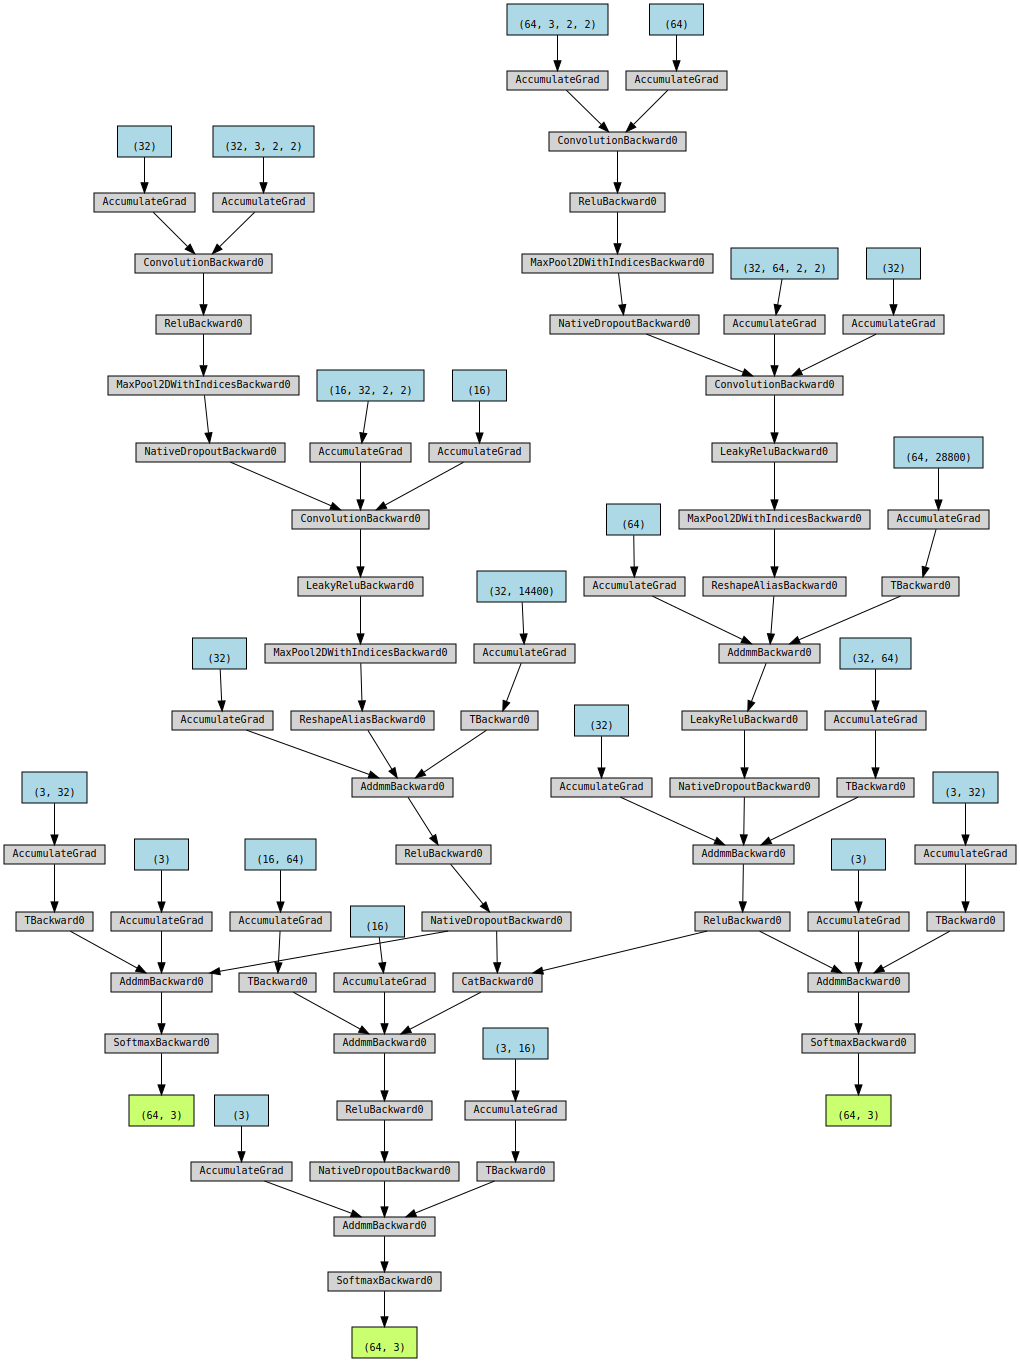

<Figure size 1000x800 with 0 Axes>

In [28]:
# Import the library
plt.figure(figsize = (10, 8))
from torchviz import make_dot

make_dot(model(X_train[0:64].to(device)),\
         show_attrs = False)

#####Define the loss and optimizer

In [29]:
LEARNING_RATE1 = 0.001
LEARNING_RATE2 = 0.001
LEARNING_RATE3 = 0.001

loss_function1 = nn.CrossEntropyLoss()
optimizer1 = optim.AdamW(params = model.parameters(), lr = LEARNING_RATE1)

loss_function2 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(params = model.parameters(), lr = LEARNING_RATE2)


loss_function3 = nn.CrossEntropyLoss()
optimizer2 = optim.Adamax(params = model.parameters(), lr = LEARNING_RATE2)

#####Define the model checkpoint

In [30]:
"""
    The checkpoint may be used directly or as the starting point for a new run, picking up where it left off.
    When training deep learning models, the checkpoint captures the weights of the model.
    These weights can be used to make predictions as-is or as the basis for ongoing training.
"""
def checkpoint(model = None, filename = None):
  if model is not None:
    return torch.save(model.state_dict(), filename)
  else:
    print("Model should be passed. !".capitalize())

def resume(model = None, filename = None):
  if filename is not None:
    return model.load_state_dict(torch.load(filename))
  else:
    print("Write the filename correctly.".capitalize())

#####Do the training

In [31]:
"""
    Create a class named Fit and default constructor
      1. EPOCHS: Define how many times the code would be executed
      2. TRAIN_LOSS: Define the train loss during the training
      3. VAL_LOSS: Define the validation or test loss during training and testing with respect to model
      4. TRAIN_ACC: Define the train accuracy that is computed during training
      5. VAL_ACC: Define the validation accuracy that is computed during training and testing
      6. BATCH_SIZE: Define the batch_size that is passed at a time to train the model and update the weights and bias

    Create a method named fit that will take a couple of parameters
      1. model: Define the model
      2. epochs: Define the epoch size that would be provided by users
      3. batch_size : Define the batch_size which is used to train the model and assist to upadte the weights and bias
      4. x: X_train - training dataset
      5. y: y_train - trainung dataset
      6. val_data: X_test - testing data
      7. val_label: y_test - testing data as a label
      8. verbose: 1 means display each iteration and epoch loss and accuracy
"""
class Fit:
  def __init__(self):
    self.EPOCHS     = -1
    self.MODEL1_TRAIN_LOSS = []
    self.MODEL2_TRAIN_LOSS = []
    self.MODEL3_TRAIN_LOSS = []
    self.MODEL1_TRAIN_ACC  = []
    self.MODEL2_TRAIN_ACC  = []
    self.MODEL3_TRAIN_ACC  = []

    self.MODEL1_VAL_LOSS   = []
    self.MODEL2_VAL_LOSS   = []
    self.MODEL3_VAL_LOSS   = []
    self.MODEL1_VAL_ACC    = []
    self.MODEL2_VAL_ACC    = []
    self.MODEL3_VAL_ACC    = []
    self.BATCH_SIZE = 32
    self.history = {'model1_loss': [], 'model1_val_loss': [], 'model1_accuracy': [], 'model1_val_accuracy': [],\
                    'model2_loss': [], 'model2_val_loss': [], 'model2_accuracy': [], 'model2_val_accuracy': [],\
                    'model3_loss': [], 'model3_val_loss': [], 'model3_accuracy': [], 'model3_val_accuracy': []}

  ############################
  #      Regularization      #
  ############################
  """
      Define the L1 regularization that would prevent the overfitting problem
      Formula of L1 regularization : loss + l1_lamba * |weight|
  """
  def l1(self, model = None, l1_lambda = 0.01):
    return sum(torch.norm(parameter, 1) for parameter in model.parameters())

  """
      Define the L2 regularization that would prevent the overfitting problem
      Formula of L2 regularization : loss + l2_lamba * weight * weight
  """
  def l2(self, model = None, l2_lambda = 0.01):
    return sum(torch.norm(parameter, 2) for parameter in model.parameters())


  ###########################
  #           Fit           #
  ###########################

  def fit(self, model = None, X = None, y = None, epochs = None, batch_size = None, val_data = None, val_label = None, verbose = 1):
    """
        Store the Epoch and batch_size in the varibales
        Convert the train and test dataset into Float that is accepted for PyTorch
        Create the DataLoader with respect to train and test
    """
    self.EPOCHS = epochs
    self.BATCH_SIZE = batch_size

    X = torch.tensor(data = X, dtype = torch.float32)
    y = torch.tensor(data = y, dtype = torch.float32)

    val_data  = torch.tensor(data = val_data, dtype = torch.float32)
    val_label = torch.tensor(data = val_label, dtype = torch.float32)

    train_loader = DataLoader(dataset = list(zip(X, y)), batch_size = self.BATCH_SIZE, shuffle = True)
    test_loader  = DataLoader(dataset = list(zip(val_data, val_label)), batch_size = self.BATCH_SIZE, shuffle = True)

    ###############################
    #          Training           #
    ###############################
    model.train()
    """
    1. Run a loop with respect to EPOCHS
    2. Extract the data and label from TRAIN_LOADER
    3. Pass the data into the model - that will return three different models (model1, model2, model3)
    4. Compute the loss functions and do the predictions
    5. Do the backward propagation to update the weights and bias
    """
    for epoch in range(self.EPOCHS):
      model1_total_train_loss = []
      model2_total_train_loss = []
      model3_total_train_loss = []
      model1_total_val_loss   = []
      model2_total_val_loss   = []
      model3_total_val_loss   = []
      model1_total_prediction = []
      model2_total_prediction = []
      model3_total_prediction = []
      model1_total_labels     = []
      model2_total_labels     = []
      model3_total_labels     = []
      model1_val_labels       = []
      model2_val_labels       = []
      model3_val_labels       = []
      model1_val_prediction   = []
      model2_val_prediction   = []
      model3_val_prediction   = []

      for (X_batch, y_batch) in TRAIN_LOADER:
        # Convert y_batch into long
        y_batch = y_batch.long()
        # Connect GPU to the X_batch and y_batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Do the predictions
        model1, model2, model3 = model(X_batch)
        # Compute the loss function
        model1_train_loss = loss_function1(model1, y_batch)
        model2_train_loss = loss_function2(model2, y_batch)
        model3_train_loss = loss_function3(model3, y_batch)

        # Do the backward propagation step to update weights and bias
        optimizer1.zero_grad()
        model1_train_loss.backward(retain_graph=True)
        optimizer1.step()

        optimizer2.zero_grad()
        model2_train_loss.backward(retain_graph=True)
        optimizer2.step()

        optimizer3.zero_grad()
        model3_train_loss.backward(retain_graph=True)
        optimizer3.step()

        # Store the train loss
        model1_total_train_loss.append(model1_train_loss.item())
        model2_total_train_loss.append(model2_train_loss.item())
        model3_total_train_loss.append(model3_train_loss.item())

        # Store the orginal train labels
        model1_total_labels.extend(y_batch.cpu().flatten().detach().numpy())
        model2_total_labels.extend(y_batch.cpu().flatten().detach().numpy())
        model3_total_labels.extend(y_batch.cpu().flatten().detach().numpy())

        # Store the predicted train labels
        model1_total_prediction.extend(torch.argmax(model1, 1).cpu().flatten().detach().numpy())
        model2_total_prediction.extend(torch.argmax(model2, 1).cpu().flatten().detach().numpy())
        model3_total_prediction.extend(torch.argmax(model3, 1).cpu().flatten().detach().numpy())

      # Compute the accuracy of training dataset
      model1_train_accuracy = accuracy_score(model1_total_labels, model1_total_prediction)
      model2_train_accuracy = accuracy_score(model2_total_labels, model2_total_prediction)
      model3_train_accuracy = accuracy_score(model3_total_labels, model3_total_prediction)

      self.MODEL1_TRAIN_ACC.append(model1_train_accuracy)
      self.MODEL2_TRAIN_ACC.append(model2_train_accuracy)
      self.MODEL3_TRAIN_ACC.append(model3_train_accuracy)

      # Store the training loss
      self.MODEL1_TRAIN_LOSS.append(np.array(model1_total_train_loss).mean())
      self.MODEL2_TRAIN_LOSS.append(np.array(model2_total_train_loss).mean())
      self.MODEL3_TRAIN_LOSS.append(np.array(model3_total_train_loss).mean())

      # Store the loss & accuracy into the history
      self.history['model1_loss'].append(np.array(model1_total_train_loss).mean())
      self.history['model1_accuracy'].append(model1_train_accuracy)

      self.history['model2_loss'].append(np.array(model2_total_train_loss).mean())
      self.history['model2_accuracy'].append(model2_train_accuracy)

      self.history['model3_loss'].append(np.array(model3_total_train_loss).mean())
      self.history['model3_accuracy'].append(model3_train_accuracy)

      #############################
      #         Validation        #
      #############################

      for (val_data, val_label) in TEST_LOADER:
        # Convert val_label into long
        val_label = val_label.long()
        # Connect GPU to val_data & val_label
        val_data  = val_data.to(device)
        val_label = val_label.to(device)

        # Do the predictions
        model1, model2, model3 = model(val_data)
        # Compute the loss function of validation
        mode1_val_loss = loss_function1(model1, val_label)
        mode2_val_loss = loss_function2(model2, val_label)
        mode3_val_loss = loss_function3(model3, val_label)

        # Store the train loss
        model1_total_val_loss.append(mode1_val_loss.item())
        model2_total_val_loss.append(mode2_val_loss.item())
        model3_total_val_loss.append(mode3_val_loss.item())

        # Store the orginal val_labels
        model1_val_labels.extend(val_label.cpu().flatten().detach().numpy())
        model2_val_labels.extend(val_label.cpu().flatten().detach().numpy())
        model3_val_labels.extend(val_label.cpu().flatten().detach().numpy())

        # Store the predicted validation data
        model1_val_prediction.extend(torch.argmax(model1, 1).cpu().flatten().detach().numpy())
        model2_val_prediction.extend(torch.argmax(model2, 1).cpu().flatten().detach().numpy())
        model3_val_prediction.extend(torch.argmax(model3, 1).cpu().flatten().detach().numpy())

      # Compute the accuracy of validation dataset
      model1_val_accuracy = accuracy_score(model1_val_prediction, model1_val_labels)
      model2_val_accuracy = accuracy_score(model2_val_prediction, model2_val_labels)
      model3_val_accuracy = accuracy_score(model3_val_prediction, model3_val_labels)

      self.MODEL1_VAL_ACC.append(model1_val_accuracy)
      self.MODEL2_VAL_ACC.append(model2_val_accuracy)
      self.MODEL3_VAL_ACC.append(model3_val_accuracy)

      # Store the validation loss
      self.MODEL1_VAL_LOSS.append(np.array(model1_total_val_loss).mean())
      self.MODEL2_VAL_LOSS.append(np.array(model2_total_val_loss).mean())
      self.MODEL3_VAL_LOSS.append(np.array(model3_total_val_loss).mean())

      # Store the loss & accuracy into the history
      self.history['model1_val_loss'].append(np.array(model1_total_val_loss).mean())
      self.history['model1_val_accuracy'].append(model1_val_accuracy)

      self.history['model2_val_loss'].append(np.array(model2_total_val_loss).mean())
      self.history['model2_val_accuracy'].append(model2_val_accuracy)

      self.history['model3_val_loss'].append(np.array(model3_total_val_loss).mean())
      self.history['model3_val_accuracy'].append(model3_val_accuracy)

      ##########################
      #         Display        #
      ##########################

      print("Epoch {}/{} ".format(epoch + 1, self.EPOCHS))

      print("{}/{} [==============] model1_loss: {} - model1_accuracy: {} - model2_loss: {} - model2_accuracy: {} - model3_loss: {} - model3_accuracy: {} model1_val_loss: {} - model1_val_accuracy: {} - model2_val_loss: {} - model2_val_accuracy: {} - model3_val_loss: {} - model3_val_accuracy: {} ".\
                                  format(TRAIN_LOADER.batch_size,\
                                        TRAIN_LOADER.batch_size,\
                                        np.array(model1_total_train_loss).mean(),\
                                        model1_train_accuracy,\
                                        np.array(model2_total_train_loss).mean(),\
                                        model2_train_accuracy,\
                                        np.array(model3_total_train_loss).mean(),\
                                        model2_train_accuracy,\
                                        np.array(model1_total_val_loss).mean(),\
                                        model1_val_accuracy,\
                                        np.array(model2_total_val_loss).mean(),\
                                        model2_val_accuracy,\
                                        np.array(model3_total_val_loss).mean(),\
                                        model2_val_accuracy))

In [32]:
# Call the model with this current directory
model_fit = Fit()

model_fit.fit(model = model,\
                X = X_train,\
                y = y_train,\
                epochs = 100,\
                batch_size = 64,\
                val_data = X_test,\
                val_label = y_test,\
                verbose = 1)

Epoch 1/100 
64/64 [==============] model1_loss: 1.0940725590501512 - model1_accuracy: 0.38457142857142856 - model2_loss: 1.099293487412589 - model2_accuracy: 0.3462857142857143 - model3_loss: 1.0933568392481123 - model3_accuracy: 0.3462857142857143 model1_val_loss: 1.092424343029658 - model1_val_accuracy: 0.376 - model2_val_loss: 1.099910060564677 - model2_val_accuracy: 0.30933333333333335 - model3_val_loss: 1.0836615761121113 - model3_val_accuracy: 0.30933333333333335 
Epoch 2/100 
64/64 [==============] model1_loss: 1.0572744373764311 - model1_accuracy: 0.4377142857142857 - model2_loss: 1.0826808980533056 - model2_accuracy: 0.372 - model3_loss: 1.0624144077301025 - model3_accuracy: 0.372 model1_val_loss: 1.0781797766685486 - model1_val_accuracy: 0.408 - model2_val_loss: 1.0941791236400604 - model2_val_accuracy: 0.36533333333333334 - model3_val_loss: 1.0888345340887706 - model3_val_accuracy: 0.36533333333333334 
Epoch 3/100 
64/64 [==============] model1_loss: 1.0393388164894921 - mo

#####Display the loss & accuracy

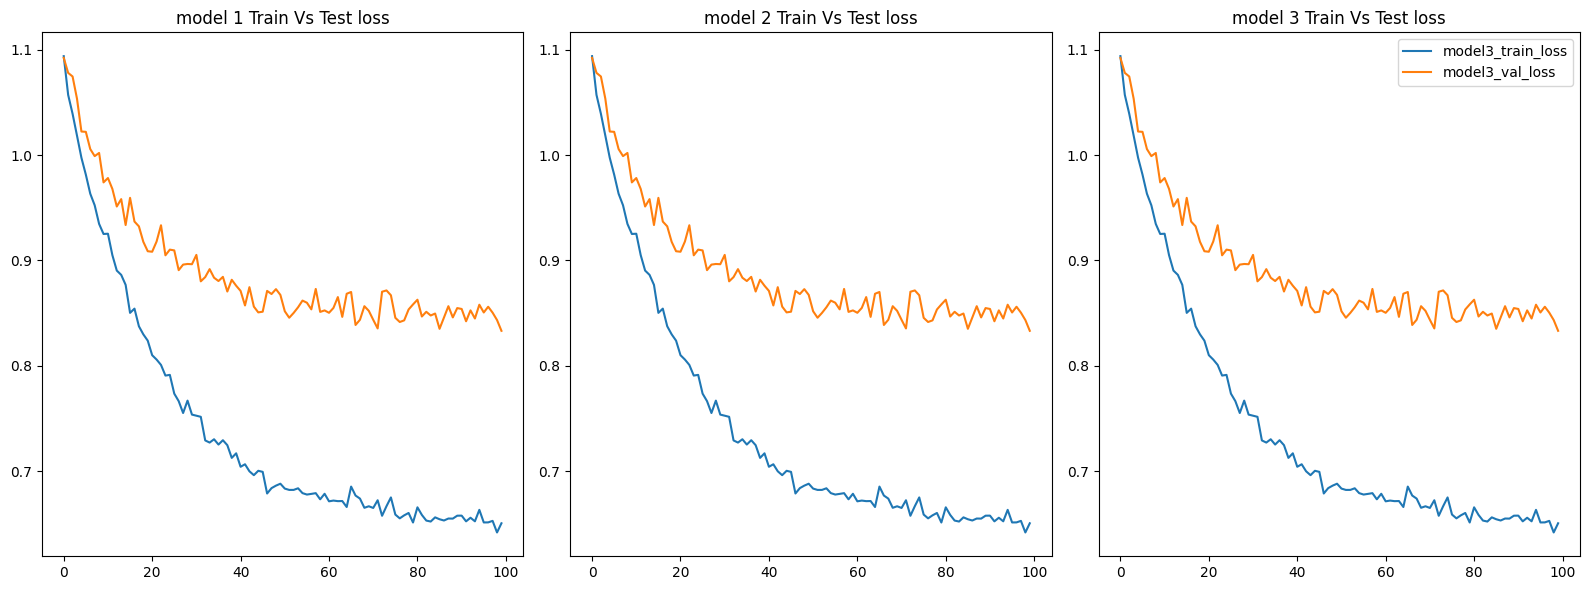

In [33]:
fig, axis = plt.subplots(1, 3, figsize = (16, 6))
axis[0].plot(np.array(model_fit.history['model1_loss']), label = 'model1_train_loss')
axis[0].plot(np.array(model_fit.history['model1_val_loss']), label = 'model1_val_loss')
axis[0].set_title('model 1 Train Vs Test loss')

axis[1].plot(np.array(model_fit.history['model1_loss']), label = 'model2_train_loss')
axis[1].plot(np.array(model_fit.history['model1_val_loss']), label = 'model2_val_loss')
axis[1].set_title('model 2 Train Vs Test loss')

axis[2].plot(np.array(model_fit.history['model1_loss']), label = 'model3_train_loss')
axis[2].plot(np.array(model_fit.history['model1_val_loss']), label = 'model3_val_loss')
axis[2].set_title('model 3 Train Vs Test loss')


plt.legend()
plt.tight_layout()
plt.show()

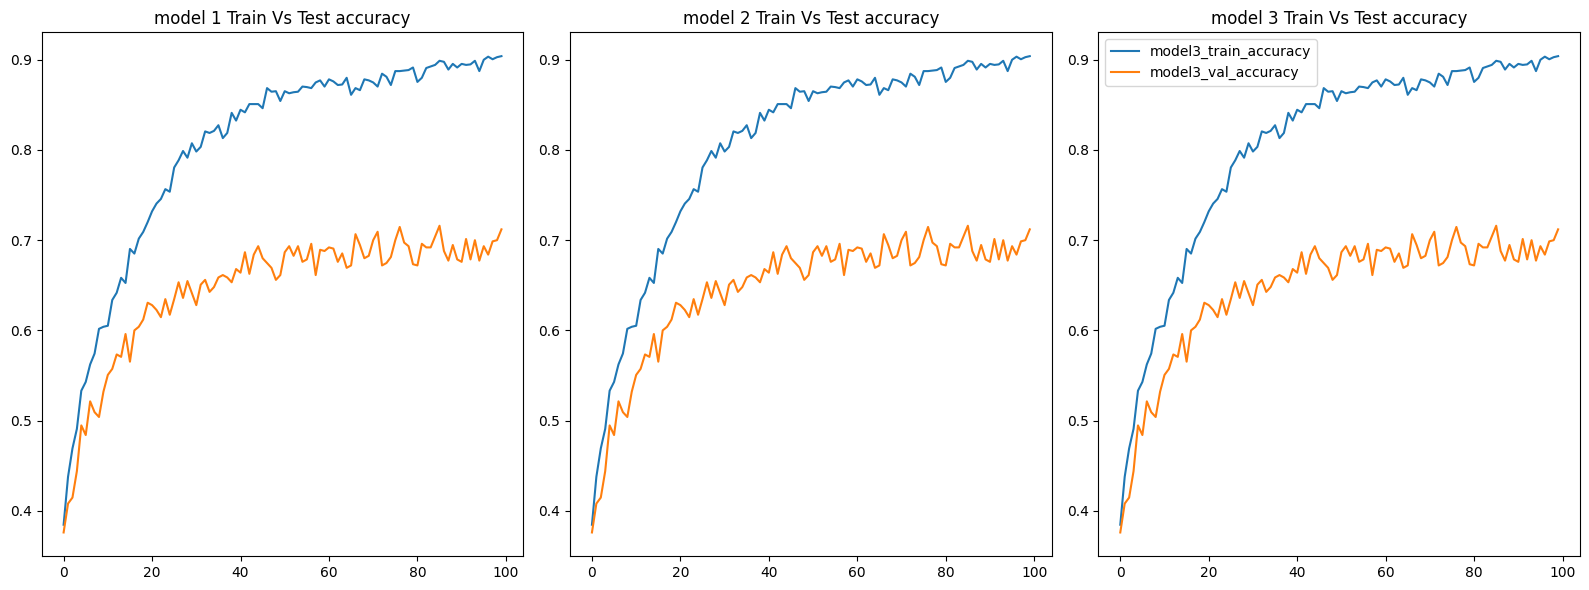

In [34]:
fig, axis = plt.subplots(1, 3, figsize = (16, 6))
axis[0].plot(np.array(model_fit.history['model1_accuracy']), label = 'model1_train_accuracy')
axis[0].plot(np.array(model_fit.history['model1_val_accuracy']), label = 'model1_val_accuracy')
axis[0].set_title('model 1 Train Vs Test accuracy')

axis[1].plot(np.array(model_fit.history['model1_accuracy']), label = 'model2_train_loss')
axis[1].plot(np.array(model_fit.history['model1_val_accuracy']), label = 'model2_val_accuracy')
axis[1].set_title('model 2 Train Vs Test accuracy')

axis[2].plot(np.array(model_fit.history['model1_accuracy']), label = 'model3_train_accuracy')
axis[2].plot(np.array(model_fit.history['model1_val_accuracy']), label = 'model3_val_accuracy')
axis[2].set_title('model 3 Train Vs Test accuracy')


plt.legend()
plt.tight_layout()
plt.show()

#####Evalution

In [49]:
TEST_LABELS  = []
TEST_PREDICT = []

for test_data, test_label in TEST_LOADER:
  test_label = test_label.long()
  test_data  = test_data.to(device)
  test_label = test_label.to(device)

  MAJORITY_VOTING = []

  model1, model2, model3 = model(test_data)

  model1_prediction = torch.argmax(model1, 1).cpu().flatten().detach().numpy()
  model2_prediction = torch.argmax(model2, 1).cpu().flatten().detach().numpy()
  model3_prediction = torch.argmax(model3, 1).cpu().flatten().detach().numpy()

  model_actutal = test_label.cpu().flatten().detach().numpy()

  for PREDICT1, PREDICT2, PREDICT3 in zip(model1_prediction, model2_prediction, model3_prediction):
    count_values = Counter([PREDICT1, PREDICT2, PREDICT3])
    MAJORITY_VOTING.append(list(dict(sorted(count_values.items(), key = lambda item: item[1], reverse = True)).keys())[0])

  TEST_PREDICT.extend(MAJORITY_VOTING)
  TEST_LABELS.extend(model_actutal)


print("accuracy  # {} ".upper().format(accuracy_score(TEST_LABELS, TEST_PREDICT)),'\n')
print("precision # {} ".upper().format(precision_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("recall    # {} ".upper().format(recall_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("f1_score  # {} ".upper().format(f1_score(TEST_LABELS, TEST_PREDICT, average = 'macro')))

ACCURACY  # 0.7306666666666667  

PRECISION # 0.7325227814970207  

RECALL    # 0.7301166374681034  

F1_SCORE  # 0.7306951096491742 


#####Classification Report


In [50]:
print(classification_report(TEST_LABELS, TEST_PREDICT))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       249
           1       0.70      0.73      0.72       230
           2       0.71      0.75      0.73       271

    accuracy                           0.73       750
   macro avg       0.73      0.73      0.73       750
weighted avg       0.73      0.73      0.73       750



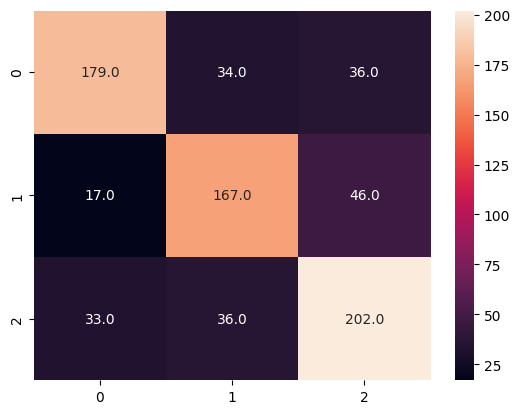

In [53]:
# Confusion Matrix
sns.heatmap(confusion_matrix(TEST_LABELS, TEST_PREDICT), annot = True, fmt=".1f")
plt.show()

#####Evaluation for validation data

In [36]:
CHANNEL = 3,
HEIGHT  = 120
WIDTH   = 120

X_val = X_val.reshape(X_val.shape[0], 3, 120, 120)

X_val = torch.tensor(data = X_val, dtype = torch.float32)
y_val = torch.tensor(data = y_val, dtype = torch.float32)

VALDATION_LOADER = DataLoader(dataset = list(zip(X_val, y_val)), batch_size = 256, shuffle = True)

TEST_LABELS  = []
TEST_PREDICT = []

for test_data, test_label in VALDATION_LOADER:
  test_label = test_label.long()
  test_data  = test_data.to(device)
  test_label = test_label.to(device)

  MAJORITY_VOTING = []

  model1, model2, model3 = model(test_data)

  model1_prediction = torch.argmax(model1, 1).cpu().flatten().detach().numpy()
  model2_prediction = torch.argmax(model2, 1).cpu().flatten().detach().numpy()
  model3_prediction = torch.argmax(model3, 1).cpu().flatten().detach().numpy()

  model_actutal = test_label.cpu().flatten().detach().numpy()

  for PREDICT1, PREDICT2, PREDICT3 in zip(model1_prediction, model2_prediction, model3_prediction):
    count_values = Counter([PREDICT1, PREDICT2, PREDICT3])
    MAJORITY_VOTING.append(list(dict(sorted(count_values.items(), key = lambda item: item[1], reverse = True)).keys())[0])

  TEST_PREDICT.extend(MAJORITY_VOTING)
  TEST_LABELS.extend(model_actutal)


print("accuracy  # {} ".upper().format(accuracy_score(TEST_LABELS, TEST_PREDICT)),'\n')
print("precision # {} ".upper().format(precision_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("recall    # {} ".upper().format(recall_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("f1_score  # {} ".upper().format(f1_score(TEST_LABELS, TEST_PREDICT, average = 'macro')))

ACCURACY  # 0.6458333333333334  

PRECISION # 0.6126984126984127  

RECALL    # 0.6122558168470822  

F1_SCORE  # 0.6057787270064755 


#####Checking the prediction

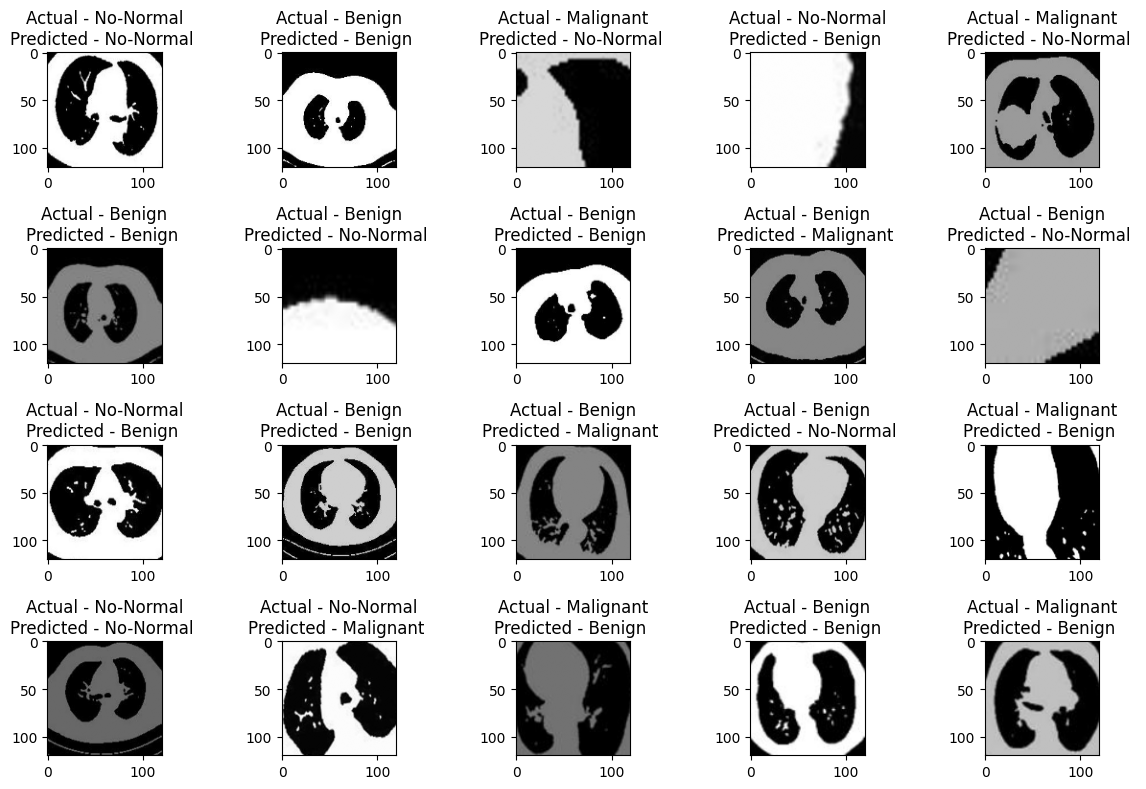

In [48]:
TEST_LABELS  = []
TEST_PREDICT = []

for test_data, test_label in TEST_LOADER:
  test_label = test_label.long()
  test_data  = test_data.to(device)
  test_label = test_label.to(device)

  MAJORITY_VOTING = []

  model1, model2, model3 = model(test_data)

  model1_prediction = torch.argmax(model1, 1).cpu().flatten().detach().numpy()
  model2_prediction = torch.argmax(model2, 1).cpu().flatten().detach().numpy()
  model3_prediction = torch.argmax(model3, 1).cpu().flatten().detach().numpy()

  model_actutal = test_label.cpu().flatten().detach().numpy()

  for PREDICT1, PREDICT2, PREDICT3 in zip(model1_prediction, model2_prediction, model3_prediction):
    count_values = Counter([PREDICT1, PREDICT2, PREDICT3])
    MAJORITY_VOTING.append(list(dict(sorted(count_values.items(), key = lambda item: item[1], reverse = True)).keys())[0])

  TEST_PREDICT.extend(MAJORITY_VOTING)
  TEST_LABELS.extend(model_actutal)
  break

IMAGE, LABEL = next(iter(TEST_LOADER))

IMAGE = IMAGE.reshape(IMAGE.shape[0], 120, 120, 3)

lower_limit = 0
upper_limit = 20
number_row  = 4
number_col  = 5

IMAGE = X[lower_limit : upper_limit]
LABEL = y[lower_limit : upper_limit]

plt.figure(figsize = (12, 8))
for index, image in enumerate(IMAGE):
  plt.subplot(number_row, number_col, index + 1)
  plt.imshow(image.reshape(120, 120, 3))
  plt.title("Actual - {}\nPredicted - {} ".format('Benign' if LABEL[index] == 0\
                                 else 'Malignant' if LABEL[index] == 1\
                                 else 'No-Normal',\

                                 'Benign' if TEST_PREDICT[index] == 0\
                                 else 'Malignant' if TEST_PREDICT[index] == 1\
                                 else 'No-Normal'))

plt.tight_layout()
plt.show()